In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, roc_auc_score


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, BayesianRidge
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR, SVC
# from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# sns.set_theme()
sns.set_palette('rocket_r')
# sns.color_palette("rocket")

## To do:
1. Preprocess:
   
   a. Standardize
   
   b. Split Data
   
   c. Normalize
3. Extract import features using RandomForestClassifier
4. Run all models storing their accuracy and f1-scores in a table

In [3]:
data = pd.read_csv('../data/model_features.csv')
data.shape

(39518, 84)

In [4]:
data.head()

,won,underdog,underdog_opp,fan_favorite,fan_favorite_opp,de,oe,te,pace,physicality_score,...,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,3mean_plus_minus,3mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
0,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-3.333333,0,0,NaN
1,1,0,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.571429,0.0,NaN,0.0,NaN,14.333333,-0.333333,1,2,NaN
2,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.444444,0.0,NaN,0.0,0.000000,14.333333,-5.666667,2,1,NaN
3,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-10.333333,3,0,0.5
4,0,1,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.333333,0.0,0.3,0.0,0.444444,13.666667,21.333333,4,2,NaN


In [5]:
models = {
    'Bayesian Ridge Regression':[BayesianRidge(), False, 'regression', 'Linear'],
    'Decision Tree Classifier':[DecisionTreeClassifier(random_state=42), False, 'classification', 'Tree'],
    'Gaussian Naïve Bayes':[GaussianNB(), False, 'classification', 'Probabilistic'],
    'Gradient Boosting for Classification':[GradientBoostingClassifier(random_state=42), False, 'classification', 'Tree'],
    'Gradient Boosting for Regression':[GradientBoostingRegressor(random_state=42), False, 'regression', 'Tree'],
    'Histogram-based Gradient Boosting Classification Tree':[HistGradientBoostingClassifier(random_state=42), True, 'classification', 'Tree'],
    'Logistic Regression':[LogisticRegression(random_state=42), False, 'classification', 'Linear'],
    'Random Forest Classifier':[RandomForestClassifier(random_state=42), False, 'classification', 'Tree'],
    'Stochastic Gradient Descent Classifier':[SGDClassifier(random_state=42), False, 'classification', 'Linear'],
    'Epsilon-Support Vector Regression (SVR)':[SVR(), False, 'regression', 'Non-Probabilistic'],
    'Support Vector Machines Classifier':[SVC(random_state=42), False, 'classification', 'Non-Probabilistic'],
    'Extreme Gradient Boosting (Xgboost) Classifier':[XGBClassifier(random_state=42), False, 'classification', 'Tree']
}

In [6]:
# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [7]:
def transform_to_binary(x):
    if x < 0:
        return 0
    elif x > 1:
        return 1
    else:
        return round(x)

In [12]:
results = {}
for model_type in models.keys():
    start = dt.datetime.now()
    # Remove fields with NaN values if model can't handel them
    if not models[model_type][1]:
        df = data.dropna(axis=1).copy()
    else:
        df = data.copy()

    # Split training and test data
    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    # Initialize the StratifiedKFold with 5 folds
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # # Standardize/Normalize the data
    # if models[model_type][2] == 'regression':
    #     scaler = MinMaxScaler() #normalization
    # else:
    #     scaler = StandardScaler() #standardization

    model = models[model_type][0]
    
    # Perform 5-fold cross-validation
    f1_scores = []
    accuracies = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # Standardize and normalize the data using the same scaler
        for scaler in [StandardScaler(), MinMaxScaler()]:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
    
        # Train the model on the training set
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        if models[model_type][2] == 'regression':
            # define vectorized sigmoid
            sigmoid_v = np.vectorize(sigmoid)
            y_pred_sig = sigmoid_v(np.array(y_pred))
            y_pred = list(map(round,y_pred_sig))

        f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))

    f1_score_strat = sum(f1_scores) / len(f1_scores)
    f1_std = np.std(f1_scores)
    accuracy_score_strat = sum(accuracies) / len(accuracies)
    acc_std = np.std(accuracies)

    runtime = (dt.datetime.now() - start).seconds
    results[model_type] = [models[model_type][3], f1_score_strat,f1_std, accuracy_score_strat,acc_std,runtime]
    print(f'{model_type}\nAccuracy: {accuracy_score_strat}\nF1-Score: {f1_score_strat}\nRuntime: {runtime}s\n')

Bayesian Ridge Regression
Accuracy: 0.5448907707368852
F1-Score: 0.6869101000079213
Runtime: 1s

Decision Tree Classifier
Accuracy: 0.6589150535260274
F1-Score: 0.6597458752643268
Runtime: 20s

Gaussian Naïve Bayes
Accuracy: 0.7211903784295515
F1-Score: 0.720993597667792
Runtime: 0s

Gradient Boosting for Classification
Accuracy: 0.7591225350799496
F1-Score: 0.7591706858648738
Runtime: 201s

Gradient Boosting for Regression
Accuracy: 0.5309731519471159
F1-Score: 0.6805700311304473
Runtime: 192s

Histogram-based Gradient Boosting Classification Tree
Accuracy: 0.7865278412441132
F1-Score: 0.784642386730614
Runtime: 8s



c:\users\nwheatle\documents\dev\march_madness_predictor\march_madness\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\nwheatle\documents\dev\march_madness_predictor\march_madness\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

Logistic Regression
Accuracy: 0.7669924421413279
F1-Score: 0.7671282191701375
Runtime: 4s

Random Forest Classifier
Accuracy: 0.7261501807595229
F1-Score: 0.7253310400226384
Runtime: 188s

Stochastic Gradient Descent Classifier
Accuracy: 0.7543907120803303
F1-Score: 0.7612972498064661
Runtime: 3s

Epsilon-Support Vector Regression (SVR)
Accuracy: 0.5907434609467732
F1-Score: 0.7062714574350897
Runtime: 1051s

Support Vector Machines Classifier
Accuracy: 0.7613494190183505
F1-Score: 0.7614074044559551
Runtime: 506s

Extreme Gradient Boosting (Xgboost) Classifier
Accuracy: 0.7349309325470111
F1-Score: 0.734285616038374
Runtime: 5s



In [13]:
df_results = pd.DataFrame(results).T
df_results.columns = ['model_type','f1_score','f1_score_σ','accuracy_score','accuracy_σ','runtime']
df_results.sort_values('f1_score', ascending=False).to_csv('../data/model_summary_phase1.csv')

In [25]:
df_results = df_results.sort_values('f1_score', ascending=False)
df_results

,model_type,f1_score,f1_score_σ,accuracy_score,accuracy_σ,runtime
Histogram-based Gradient Boosting Classification Tree,Tree,0.784642,0.004193,0.786528,0.004313,8
Logistic Regression,Linear,0.767128,0.003849,0.766992,0.00433,4
Support Vector Machines Classifier,Non-Probabilistic,0.761407,0.003563,0.761349,0.003947,506
Stochastic Gradient Descent Classifier,Linear,0.761297,0.018116,0.754391,0.011109,3
Gradient Boosting for Classification,Tree,0.759171,0.00411,0.759123,0.004552,201
Extreme Gradient Boosting (Xgboost) Classifier,Tree,0.734286,0.003457,0.734931,0.003184,5
Random Forest Classifier,Tree,0.725331,0.002559,0.72615,0.002873,188
Gaussian Naïve Bayes,Probabilistic,0.720994,0.002472,0.72119,0.002638,0
Epsilon-Support Vector Regression (SVR),Non-Probabilistic,0.706271,0.000388,0.590743,0.001022,1051
Bayesian Ridge Regression,Linear,0.68691,0.001493,0.544891,0.00314,1


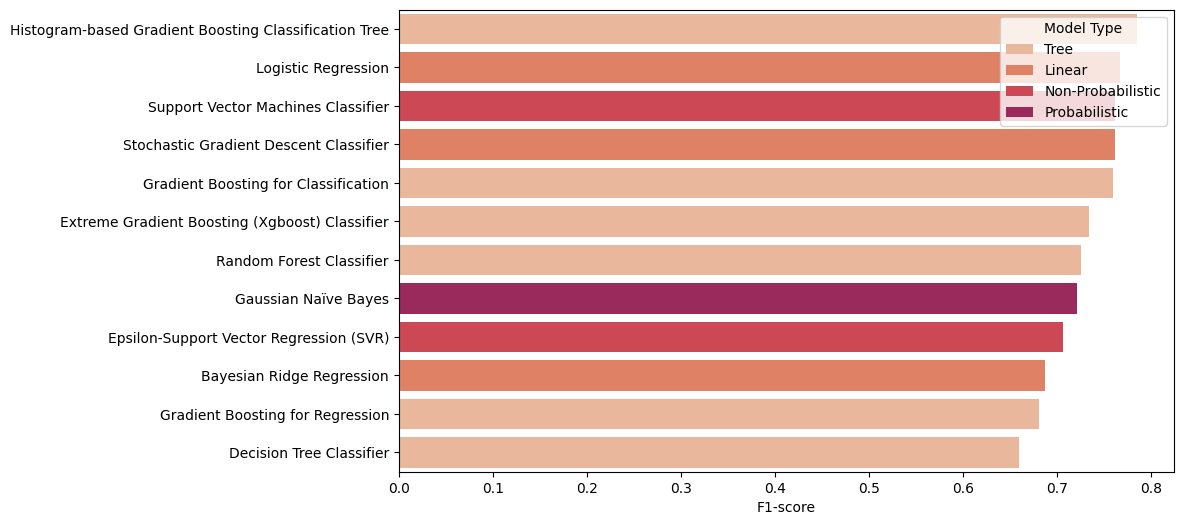

In [31]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, y=df_results.index, x='f1_score', hue='model_type')

# plt.title('Figure 1 - Attempted Models Ranked by F1-score')
plt.ylabel(None)
plt.xlabel('F1-score')
plt.legend(title='Model Type')
plt.savefig('../visuals/models_ranked_by_f1_score.png', bbox_inches='tight')

## Identify important features using Random Forest Classifier

In [19]:
# Split training and test data
df = data.fillna(0)
# df = data.copy()
X = df.iloc[:,1:]
y = df.iloc[:,0]

rf_model = RandomForestClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
n = 10
feature_importance = {key:value for key,value in sorted(zip(data.columns.tolist()[1:], rf_model.feature_importances_), key=lambda x: x[1], reverse=True)}
top_features = list(feature_importance.keys())[:n]

In [21]:
feature_importance

{'matchup_win_rate': 0.09216539515289807,
 'game_win_rate_opp': 0.047166081448207886,
 'game_win_rate': 0.04426656526390934,
 'srs': 0.029253765163854393,
 'srs_opp': 0.028720162530262033,
 'te_opp': 0.027641032182180454,
 '3mean_plus_minus': 0.026447038041928994,
 'fan_favorite': 0.026084737689372604,
 'te': 0.02599155157435543,
 '3mean_plus_minus_opp': 0.025096990547471634,
 'fan_favorite_opp': 0.023729507570017953,
 'oe': 0.015127722275135924,
 'oe_opp': 0.013761303828308789,
 'de': 0.013630759229606333,
 'de_opp': 0.013099641233576372,
 'sos': 0.012629682229762115,
 'sos_opp': 0.012165394791481262,
 'gpt_sent_score_avg_opp': 0.01157555597000297,
 'gpt_sent_score_avg': 0.011078737616556193,
 'fg%_opp': 0.0109709485257235,
 'ast_to_tov_opp': 0.010925652730930638,
 'win_streak_opp': 0.010635023116265123,
 'fg%': 0.010583792083799474,
 'ast_to_tov': 0.01036017692240736,
 'win_streak': 0.00994675316863641,
 'blk': 0.009174218486837133,
 'fg': 0.00906338792341,
 'blk_opp': 0.008968826668

In [23]:
top_features

['matchup_win_rate',
 'game_win_rate_opp',
 'game_win_rate',
 'srs',
 'srs_opp',
 'te_opp',
 '3mean_plus_minus',
 'fan_favorite',
 'te',
 '3mean_plus_minus_opp']

## Run models only using top features

In [ ]:
results = {}
data1 = data[['won']+top_features]
for model_type in models.keys():
    start = dt.datetime.now()
    # Remove fields with NaN values if model can't handel them
    if not models[model_type][1]:
        df = data1.dropna(axis=1).copy()
    else:
        df = data1.copy()

    # Split training and test data
    X = df.iloc[:,1:]
    y = df.iloc[:,0]

    # Initialize the StratifiedKFold with 5 folds
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # # Standardize/Normalize the data
    # if models[model_type][2] == 'regression':
    #     scaler = MinMaxScaler() #normalization
    # else:
    #     scaler = StandardScaler() #standardization

    model = models[model_type][0]
    
    # Perform 5-fold cross-validation
    f1_scores = []
    accuracies = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # Standardize and normalize the data using the same scaler
        for scaler in [StandardScaler(), MinMaxScaler()]:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
    
        # Train the model on the training set
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        if models[model_type][2] == 'regression':
            # define vectorized sigmoid
            sigmoid_v = np.vectorize(sigmoid)
            y_pred_sig = sigmoid_v(np.array(y_pred))
            y_pred = list(map(round,y_pred_sig))

        f1_scores.append(f1_score(y_test, y_pred))
        accuracies.append(accuracy_score(y_test, y_pred))

    f1_score_strat = sum(f1_scores) / len(f1_scores)
    f1_std = np.std(f1_scores)
    accuracy_score_strat = sum(accuracies) / len(accuracies)
    acc_std = np.std(accuracies)

    runtime = (dt.datetime.now() - start).seconds
    results[model_type] = [models[model_type][3], f1_score_strat,f1_std, accuracy_score_strat,acc_std,runtime]
    print(f'{model_type}\nAccuracy: {accuracy_score_strat}\nF1-Score: {f1_score_strat}\nRuntime: {runtime}s\n')

In [ ]:
df_results = pd.DataFrame(results).T
df_results.columns = ['model_type','f1_score','f1_score_σ','accuracy_score','accuracy_σ','runtime']
df_results.sort_values('f1_score', ascending=False).to_csv('../data/model_summary_phase2.csv')
df_results.sort_values('f1_score', ascending=False)

In [ ]:
df_results_total = pd.read_csv('../data/model_summary_phase1.csv').rename(columns={'Unnamed: 0':'model'})
df_results_top10 = pd.read_csv('../data/model_summary_phase2.csv').rename(columns={'Unnamed: 0':'model'})

In [ ]:
df_results_top10['model'] = df_results_top10['model'].apply(lambda x:x+'_10')

In [ ]:
combined_results = pd.concat([df_results_total,df_results_top10]).set_index('model').sort_values('f1_score', ascending=False)
combined_results

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(data=combined_results, y=combined_results.index, x='f1_score', hue='model_type')

plt.title('Figure 1 - Attempted Models Ranked by F1-score')
plt.ylabel('Model')
plt.xlabel('F1-score')
plt.legend(title='Model Type')

In [ ]:
plt.figure(figsize=(15,6))
combined_results_runtime = combined_results.sort_values('runtime',ascending=False)
sns.barplot(data=combined_results_runtime, y=combined_results_runtime.index, x='runtime', hue='model_type')

In [ ]:
sns.scatterplot(data=combined_results,x='runtime',y='f1_score',hue='model_type',)

## Tune Top Three Models:

- Histogram-based Gradient Boosting Classification Tree
- Logistic Regression
- Stochastic Gradient Descent Classifier

In [11]:
models_to_tune = {
    'Histogram-based Gradient Boosting Classification Tree':[HistGradientBoostingClassifier(), True, 'classification', 'Tree'],
    'Logistic Regression':[LogisticRegression(), False, 'classification', 'Linear'],
    'Stochastic Gradient Descent Classifier':[SGDClassifier(), False, 'classification', 'Linear'],
}

In [12]:
tuned_results = {}

## Tune Histogram-based Gradient Boosting Classification Tree

In [13]:
model_name = 'Best Histogram-based Gradient Boosting Classification Tree'
start = dt.datetime.now()
df = data.copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


hgb_classifier = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [15, 20, 25]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hgb_grid_search = GridSearchCV(hgb_classifier, param_grid, cv=stratified_cv, scoring='f1')
hgb_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", hgb_grid_search.best_params_)

# Get the best model from the grid search
best_hgb_model = hgb_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_hgb_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', hgb_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in hgb_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 25}
Best Histogram-based Gradient Boosting Classification Tree
CV Training Best F1-Score: 0.784671704751592
Test F1-Score: 0.791757327531038
Test Accuracy: 0.7941548582995951
Tuning Runtime: 760 sec


## Tune Logistic Regression

In [14]:
warnings.filterwarnings("ignore")
model_name = 'Best Logistic Regression'
start = dt.datetime.now()
df = data.dropna(axis=1).copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


lg_classifier = LogisticRegression(random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs','liblinear', 'saga'],
    'max_iter':[50,100,1000]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lg_grid_search = GridSearchCV(lg_classifier, param_grid, cv=stratified_cv, scoring='f1')
lg_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", lg_grid_search.best_params_)

# Get the best model from the grid search
best_lg_model = lg_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_lg_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', lg_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in lg_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

Best Hyperparameters: {'C': 1, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression
CV Training Best F1-Score: 0.7661154054421777
Test F1-Score: 0.7694447957506007
Test Accuracy: 0.7693572874493927
Tuning Runtime: 1176 sec


## Tune Stochastic Gradient Descent

In [15]:
warnings.filterwarnings("always")
model_name = 'Best Stochastic Gradient Descent'
start = dt.datetime.now()
df = data.dropna(axis=1).copy()

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


sgd_classifier = SGDClassifier(random_state=42)

param_grid = {
    'alpha': [0.00005, 0.0001, 0.001],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'log', 'modified_huber'],
    'max_iter':[500,1000,1500]
}

# Use StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

sgd_grid_search = GridSearchCV(sgd_classifier, param_grid, cv=stratified_cv, scoring='f1')
sgd_grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", sgd_grid_search.best_params_)

# Get the best model from the grid search
best_sgd_model = sgd_grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_sgd_model.predict(X_test)

# Evaluate the accuracy of the model
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

runtime = (dt.datetime.now() - start).seconds
print(model_name)
print('CV Training Best F1-Score:', sgd_grid_search.best_score_)
print("Test F1-Score:", f1)
print("Test Accuracy:", accuracy)
print('Tuning Runtime:', runtime, 'sec')

parameters_str = ', '.join([f'{key}: {value}' for key,value in sgd_grid_search.best_params_.items()])
tuned_results[model_name] = [f1,accuracy,parameters_str, runtime]

c:\users\nwheatle\documents\dev\march_madness_predictor\march_madness\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\users\nwheatle\documents\dev\march_madness_predictor\march_madness\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\nwheatle\documents\dev\march_madness_predictor\march_madness\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\users\nwheatle\documents\dev\march_madn

Best Hyperparameters: {'alpha': 5e-05, 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l2'}
Best Stochastic Gradient Descent
CV Training Best F1-Score: 0.7712589969996045
Test F1-Score: 0.7695455524445403
Test Accuracy: 0.729251012145749
Tuning Runtime: 106 sec


In [16]:
best_models = pd.DataFrame(tuned_results).T
best_models.columns = ['f1_score','accuracy_score','parameters','cv_runtime(sec)']
best_models.to_csv('../data/best_models.csv')
best_models

,f1_score,accuracy_score,parameters,cv_runtime(sec)
Best Histogram-based Gradient Boosting Classification Tree,0.791757,0.794155,"learning_rate: 0.05, max_depth: None, max_iter...",760
Best Logistic Regression,0.769445,0.769357,"C: 1, max_iter: 50, penalty: l1, solver: libli...",1176
Best Stochastic Gradient Descent,0.769546,0.729251,"alpha: 5e-05, loss: hinge, max_iter: 500, pena...",106
